# Paramétrage de l'environnement de travail et import des packages

In [6]:
import sys
from pathlib import Path

In [7]:
ROOT = Path.cwd().parents[0]

RAW_DATA = ROOT / "01_data" / "01_raw"
PROCESSED_DATA = ROOT / "01_data" / "02_processed"

NOTEBOOK = ROOT / "02_notebooks"

FONCTIONS = ROOT / "03_fonctions"

%load_ext autoreload
%autoreload 2
sys.path.append(str(ROOT / "03_fonctions"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd
import numpy as np

import joblib

from cheat_tools.data_manipulation import multi_astype
from sklearn import set_config

from cheat_tools.machine_learning import waterfall_plot
import shap

# Interprétation SHAP du modèle

**Import des données**

In [9]:
X_train = pd.read_csv(PROCESSED_DATA / "04_machine_learning" / "X_train.csv")

multi_astype(
    X_train,
    ["property_type","taille_agglomeration","nb_rooms_bins"],
    "string"
)

property_type: object → string
taille_agglomeration: object → string
nb_rooms_bins: object → string

Succès: 3/3


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21317 entries, 0 to 21316
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              21317 non-null  string 
 1   taille_agglomeration       21317 non-null  string 
 2   est_attrait_touristique    21317 non-null  int64  
 3   nb_rooms_bins              21317 non-null  string 
 4   approximate_latitude       21317 non-null  float64
 5   approximate_longitude      21317 non-null  float64
 6   densite_services_rayon     21317 non-null  float64
 7   size_c                     21189 non-null  float64
 8   taux_criminalite_1000_c    21140 non-null  float64
 9   population_c               21161 non-null  float64
 10  nb_photos_c                21317 non-null  float64
 11  size_2_c                   21189 non-null  float64
 12  taux_criminalite_1000_2_c  21140 non-null  float64
 13  population_2_c             21161 non-null  flo

**Import du modèle**

In [12]:
model = joblib.load(ROOT / "04_model" / "housing_logit_model.joblib")

**Initialisation**

In [13]:
set_config(transform_output="pandas")

In [14]:
# Appliquer toutes les étapes sans le modèle (étape 1 | étape 2 | étape 3)
X_train_proc = model[:-1].transform(X_train)

# Récuperer le modèle "nu"
logit_final = model.named_steps["model"]


# Initialisation de l'explainer
explainer = shap.LinearExplainer(logit_final, X_train_proc)

shap_values = explainer(X_train_proc)  

**Feature Importance**

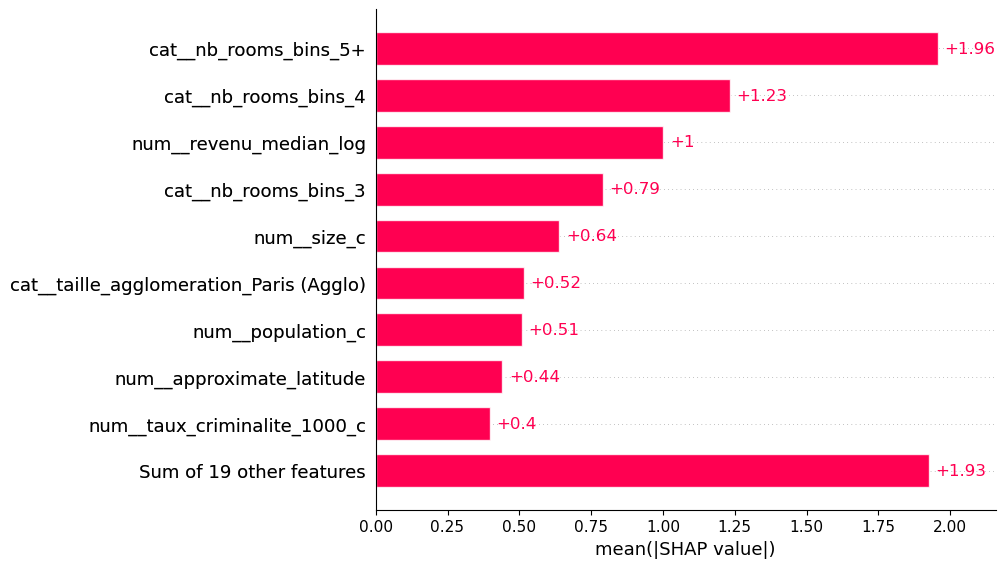

In [15]:
shap.plots.bar(shap_values, max_display=10)

**Beeswarm Plot**

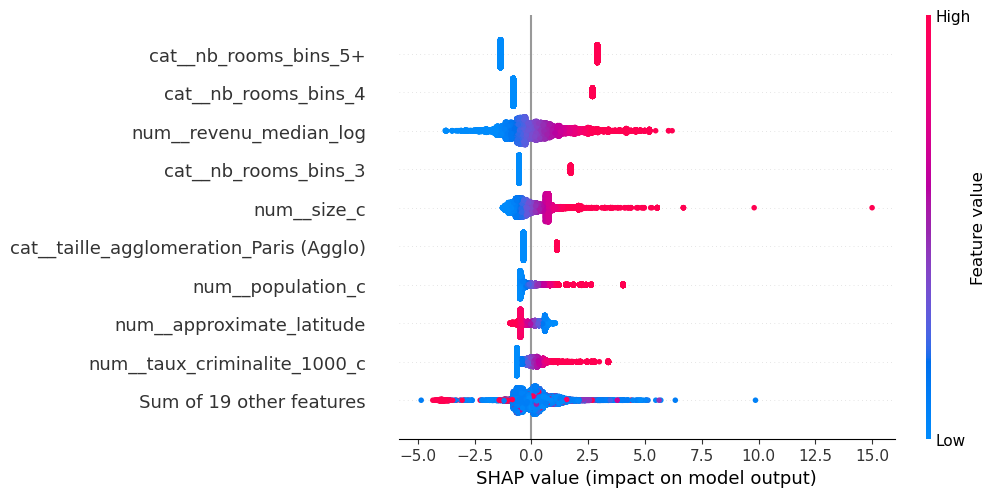

In [16]:
shap.plots.beeswarm(shap_values, max_display=10)

**Waterfall Plot**

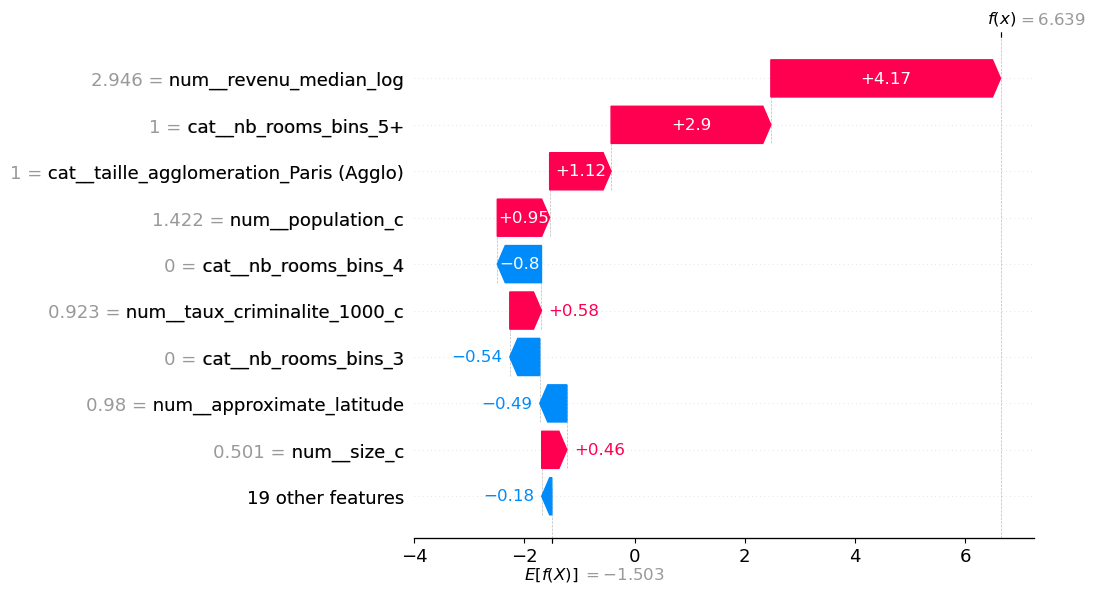

In [17]:
waterfall_plot(
    shap_values,
    X_train_proc,
    89,
    max_display=10
)

# Note explicative du notebook

Cette dernière étape vise à rendre le modèle prédictif pleinement interprétable à travers l’analyse des valeurs SHAP.

L’objectif est double :
- Comprendre quels facteurs structurent globalement les prédictions.
- Expliquer localement une prédiction individuelle.

---

## 1. Importance globale des variables

L’analyse des valeurs SHAP moyennes confirme les résultats économétriques et machine learning :

Variables les plus structurantes :

- Nombre de pièces (notamment 5+ pièces)
- Revenu médian local (log)
- Surface du bien
- Localisation à Paris
- Population locale
- Taux de criminalité
- Densité de services

Ces variables présentent les contributions moyennes absolues les plus élevées sur la sortie du modèle.

La structure du marché immobilier apparaît clairement :
1. Caractéristiques intrinsèques du bien  
2. Niveau socio-économique du territoire  
3. Attractivité et densité urbaine  

---

## 2. Analyse directionnelle (Beeswarm)

Le graphique SHAP “beeswarm” montre :

- Les valeurs élevées de revenu médian augmentent fortement la probabilité de prix élevé.
- Les biens de grande taille et avec plus de pièces ont un impact positif important.
- Paris (agglomération) génère un effet fortement positif.
- Les effets non linéaires (surface, population, criminalité) sont visibles dans la dispersion des contributions.

Le modèle ne capture pas uniquement des relations linéaires simples, mais des effets conditionnels cohérents.

---

## 3. Interprétation locale (Waterfall)

L’analyse individuelle met en évidence :

- La contribution cumulative des variables à partir de la probabilité moyenne.
- Les variables dominantes pour une prédiction donnée.
- Le rôle déterminant du revenu médian, du nombre de pièces et de la localisation.

Exemple observé :
- Revenu médian élevé : contribution très positive.
- Bien avec 5+ pièces : effet fortement positif.
- Localisation Paris : effet additionnel significatif.

Cela permet d’expliquer précisément pourquoi un bien est classé “haut prix”.

---
